# Matriz Getis Ord Sul

## Bibliotecas

In [ ]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 30kB/s 
     |████████████████████████████████| 14.7MB 301kB/s 
     |████████████████████████████████| 225kB 2.7MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=4d0869c36275f25ec79ca0bfe90ec908981feba97dcd46a2828dc7587b0c3c58
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
     |████████████████████████████████| 2.4MB 6.1MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 266kB 32.5MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 235kB 30.1MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379082 sha256=f2ccb1eb14707abf5dc9b1922b8997f19c64

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [2]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [3]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [4]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [5]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [6]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [7]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [8]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [9]:
dados.reset_index(level = 0, inplace = True)

In [10]:
dados.shape

(2293, 9)

In [11]:
dados = dados.merge(cod, on='mun')

In [12]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [13]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [14]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [15]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [16]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [17]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [18]:
dados_br = cod_dados.merge(seguro, how='left')

In [19]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

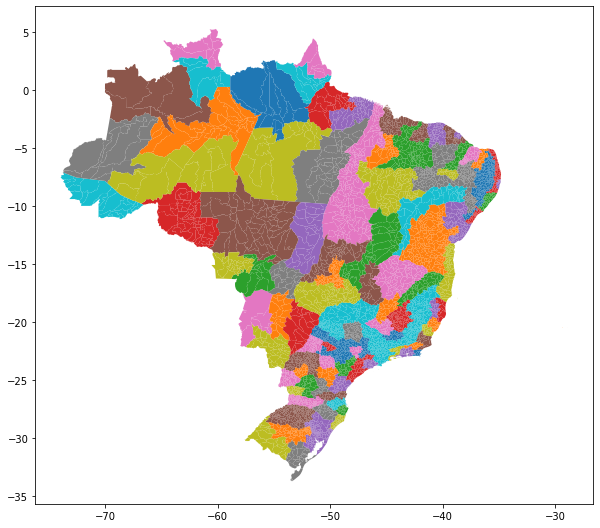

In [21]:
dados_br.plot(column='nome_meso', figsize=(10, 10), k=4); # , cmap='OrRd',  cmap='plasma'

## Sul

In [22]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

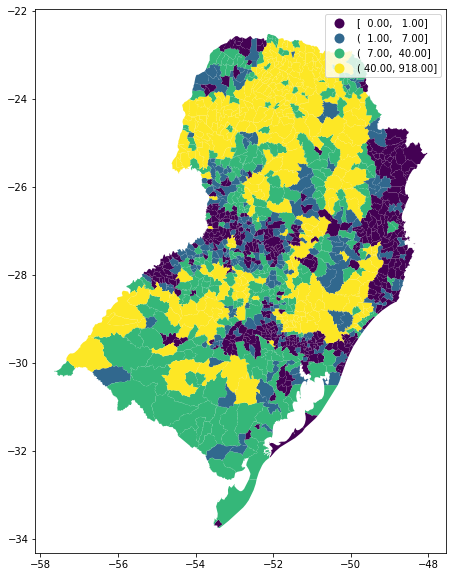

In [23]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True, k=4); # , cmap='OrRd'

## Matriz de G de Getis-Ord - Sul

Teste de construção de uma matriz de G de Getis-Ord para cada variável


### Criando a matriz

In [24]:
getis_matrix_sul = dados_sul

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0', 'rm'] # , 'geometry'
getis_matrix_sul = getis_matrix_sul.drop(retirar, axis = 1)

### G de Getis Ord local para variáveis - Sul

In [26]:
getis_matrix_sul.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
# demora um pouco
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [28]:
for variavel in getis_matrix_sul.drop(['nome_mun', 'geometry'], axis=1).columns:
    getis_matrix_sul[variavel] = G_Local(dados_sul[variavel].values, w).Zs

In [29]:
getis_matrix_sul = getis_matrix_sul.set_index('nome_mun')

In [30]:
getis_matrix_sul.describe()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.068056,0.077851,0.062726,0.062220,0.027942,0.051661,0.070182,0.034747
std,0.818446,0.745528,0.686416,0.687083,0.749441,0.874580,0.914158,0.779678
min,-0.473328,-0.471005,-0.369799,-0.368972,-0.274768,-0.537919,-0.712162,-0.309403
25%,-0.426997,-0.426565,-0.340833,-0.341460,-0.271973,-0.506889,-0.598547,-0.301196
50%,-0.261540,-0.215295,-0.194940,-0.199291,-0.230421,-0.356053,-0.281017,-0.252032
75%,0.185899,0.287653,0.189305,0.187701,-0.039191,0.158232,0.325219,-0.042124
max,5.829321,5.897918,6.259104,5.968922,9.664410,4.135955,3.665731,8.876354


### Mapa G de Getis Ord - Sul

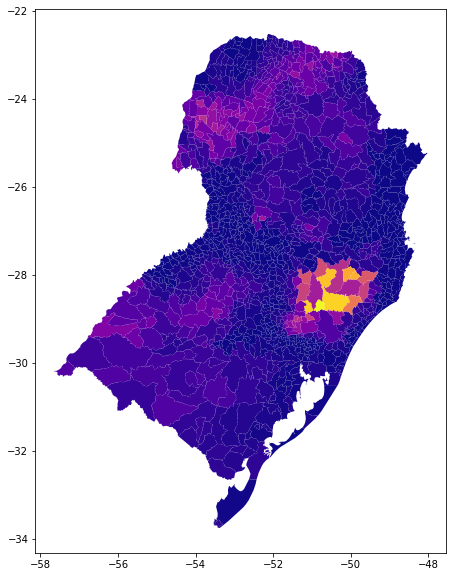

In [31]:
getis_matrix_sul.plot(column='soma_premio_total_mil', figsize=(10, 10),  k=4, cmap='plasma'); # , cmap='OrRd'

## Análise de agrupamento - G de Getis-Ord - Sul

In [32]:
# subselecionar variáveis
X = getis_matrix_sul.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [33]:
Z = linkage(X, method='ward')

In [34]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

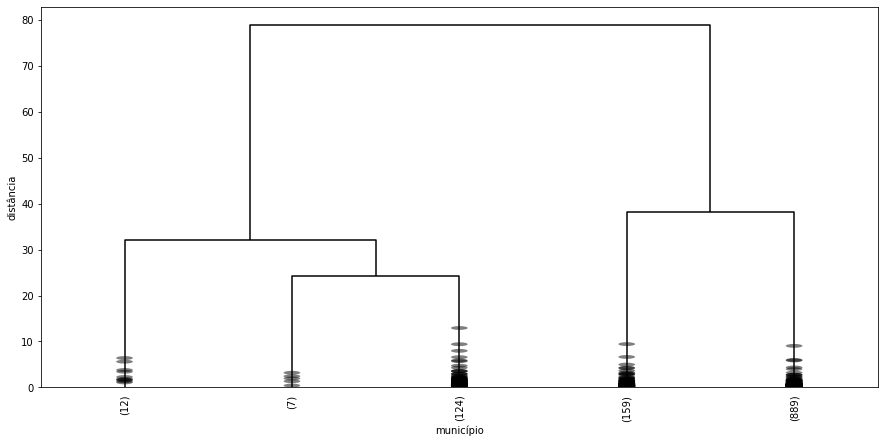

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [36]:
Z = linkage(X, method='ward')

In [37]:
# definir a distância de corte baseando no dendrograma
max_d = 20
grupos = cut_tree(Z, height=max_d)

### Métricas

In [39]:
dados_metrics_sul = getis_matrix_sul.drop('geometry', axis=1)

In [40]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

1117.88 0.85 0.59


In [69]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
getis_matrix_sul['grupo'] = grupos
# moran_matrix.head(2)

In [70]:
# contagem de observações em cada grupo
getis_matrix_sul.grupo.value_counts()

1    889
2    159
0    124
3     12
4      7
Name: grupo, dtype: int64

In [71]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,1.618150,1.395628,1.174136,1.189063,0.985442,1.740953,1.918667,1.209681,3.943548
1,-0.273890,-0.233063,-0.206189,-0.209001,-0.223118,-0.367319,-0.374345,-0.247045,2.456693
2,0.371137,0.421723,0.328304,0.325584,0.258825,0.923749,0.966443,0.274597,3.056604
3,4.395400,2.681850,1.935848,1.999980,5.381959,1.975409,1.559843,5.362765,6.000000
4,1.733886,3.945571,5.283624,5.242076,0.528489,0.230845,0.868757,0.427512,4.000000


In [72]:
# mediana das variáveis para cada grupo
getis_matrix_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,1.528732,1.302431,1.052408,1.071980,0.824081,1.841091,2.046928,1.175909,6
1,-0.365900,-0.352708,-0.298131,-0.299308,-0.257268,-0.448519,-0.462548,-0.283118,0
2,0.346387,0.374833,0.296977,0.297728,0.153393,0.827377,0.906375,0.150808,2
3,4.290481,2.828896,1.830369,1.909381,5.010522,2.294724,1.348135,4.780325,7
4,1.893713,3.969912,5.414236,5.268418,0.520673,0.039589,0.609513,0.433683,4


### As observações de cada grupo

In [73]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos G de Getis-Ords - Sul

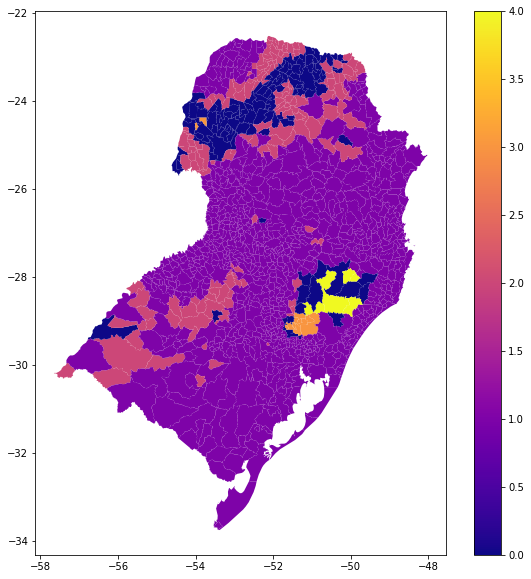

In [75]:
getis_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap='plasma'); # , cmap='OrRd'

## K-Médias G de Getis-Ord - Sul

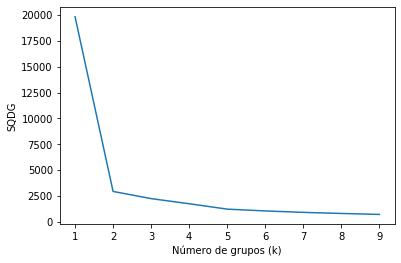

In [76]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(getis_matrix_sul.drop('geometry', axis=1))
    getis_matrix_sul['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [77]:
k = 5

In [78]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [79]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
getis_matrix_sul['grupo'] = kmeans.labels_

### Métricas

In [80]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

1305.08 0.78 0.59


In [81]:
# contagens
getis_matrix_sul.grupo.value_counts()

0    829
1    223
2    114
4     13
3     12
Name: grupo, dtype: int64

In [82]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [83]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,-0.308670,-0.279372,-0.240951,-0.243218,-0.234231,-0.392711,-0.421571,-0.258471,2.071170
1,0.355174,0.463467,0.351046,0.343396,0.151810,0.578682,0.749544,0.160764,2.811659
2,1.648641,1.301798,1.036783,1.059678,1.090652,2.048565,2.098768,1.332802,2.745614
3,4.395400,2.681850,1.935848,1.999980,5.381959,1.975409,1.559843,5.362765,7.000000
4,1.311433,3.106098,4.211466,4.180903,0.360416,0.061451,0.610936,0.270219,6.923077


In [84]:
# mediana das variáveis para cada grupo
getis_matrix_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,-0.382112,-0.372921,-0.307093,-0.308310,-0.260713,-0.465646,-0.493060,-0.289690,1
1,0.310121,0.397888,0.296977,0.297728,0.038184,0.521558,0.636353,0.048720,4
2,1.593749,1.224535,1.012930,1.039108,0.949454,2.113990,2.133097,1.203046,2
3,4.290481,2.828896,1.830369,1.909381,5.010522,2.294724,1.348135,4.780325,7
4,1.368501,2.673483,4.008760,4.026924,0.332590,-0.074062,0.295570,0.291655,6


In [85]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com G de Getis Ord - k-médias - Sul

In [86]:
getis_matrix_sul['grupo'] = getis_matrix_sul['grupo'].astype('category')

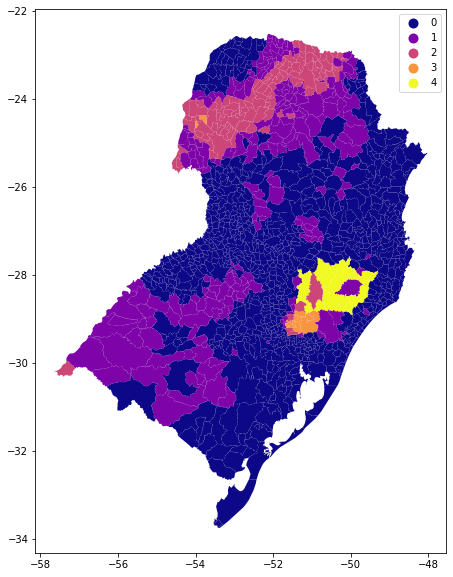

In [87]:
getis_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap='plasma'); # , cmap='OrRd'